# Adding non-stationarity

In this notebook we add non-stationarity into the nursery dataset.

Here we follow the setting in [1] and just invert the class labels at a specified time point, simulating concept shift.

[1] Context Attentive Bandits: Contextual Bandit with Restricted Context https://arxiv.org/pdf/1705.03821.pdf


In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [134]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import algorithms
import evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
np.random.seed(42)

In [136]:
csv_file = 'experiments/nursery/nursery.csv'

In [137]:
df = pd.read_csv(csv_file)

In [138]:
df

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [139]:
df_num = df.astype('category')

In [140]:
df_num['final evaluation']

0         recommend
1          priority
2         not_recom
3         recommend
4          priority
            ...    
12955    spec_prior
12956     not_recom
12957    spec_prior
12958    spec_prior
12959     not_recom
Name: final evaluation, Length: 12960, dtype: category
Categories (5, object): ['not_recom', 'priority', 'recommend', 'spec_prior', 'very_recom']

In [141]:
# Order categories correctly, because order has meaning.
df_num.parents = df_num.parents.cat.reorder_categories(['usual', 'pretentious', 'great_pret'])
df_num.has_nurs = df_num.has_nurs.cat.reorder_categories(
    ['proper', 'less_proper',  'improper', 'critical', 'very_crit']
)
df_num.form = df_num.form.cat.reorder_categories(['complete', 'completed', 'incomplete', 'foster'])
df_num.children = df_num.children.cat.reorder_categories(['1', '2', '3', 'more'])
df_num.housing = df_num.housing.cat.reorder_categories(['convenient', 'less_conv', 'critical'])
df_num.finance = df_num.finance.cat.reorder_categories(['convenient', 'inconv'])
df_num.social = df_num.social.cat.reorder_categories(['nonprob', 'slightly_prob', 'problematic'])
df_num.health = df_num.health.cat.reorder_categories(['not_recom', 'recommended', 'priority'])
df_num['final evaluation'] = df_num['final evaluation'].cat.reorder_categories(
    ['not_recom', 'recommend',  'very_recom', 'priority', 'spec_prior',]
)


In [142]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [143]:
for colname in df:
    df_num[colname] = df_num[colname].cat.codes + 1

In [144]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,1,1,1,1,1,1,1,2,2
1,1,1,1,1,1,1,1,3,4
2,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,2,2,2
4,1,1,1,1,1,1,2,3,4
...,...,...,...,...,...,...,...,...,...
12955,3,5,4,4,3,2,2,3,5
12956,3,5,4,4,3,2,2,1,1
12957,3,5,4,4,3,2,3,2,5
12958,3,5,4,4,3,2,3,3,5


In [189]:
# Features are dropped according to their usefulness for the linear regression model.
# final evaluation is target variable

all_contexts = df_num.drop(['parents', 'has_nurs', 'social', 'social', 'final evaluation'], axis=1).to_numpy()
# all_contexts = df_num.drop(['final evaluation'], axis=1).to_numpy()

In [190]:
all_contexts.shape

(12960, 5)

In [191]:
all_contexts

array([[1, 1, 1, 1, 2],
       [1, 1, 1, 1, 3],
       [1, 1, 1, 1, 1],
       ...,
       [4, 4, 3, 2, 2],
       [4, 4, 3, 2, 3],
       [4, 4, 3, 2, 1]], dtype=int8)

In [192]:
y = df_num['final evaluation']

In [193]:
np.sum(np.where(y == 3, 1, 0))

328

In [194]:
unique = np.unique(y)
all_rewards = np.zeros((y.shape[0], len(unique)))
for n_arm, y_value in enumerate(unique):
    all_rewards[:, n_arm] = np.where(y == y_value, 1, 0)
    

In [195]:
all_rewards

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

In [196]:
np.array(np.sum(all_rewards, axis=0), dtype=int)

array([4320,    2,  328, 4266, 4044])

### Fixed costs

In [197]:
costs_vector = np.zeros(all_contexts.shape)
for i in range(all_contexts.shape[0]):
    costs_vector[i, :] = np.array([0.01]*all_contexts.shape[1])

costs_vector.shape

(12960, 5)

In [231]:
costs_vector

array([[0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01],
       ...,
       [0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01]])

### Find which features are useful

It might be useful to move this to another notebook later for better organization.

In [198]:
from sklearn.linear_model import LinearRegression, LogisticRegression


coefs = np.zeros((5, all_contexts.shape[1]))
for n_arm in range(5):
    print(n_arm)
    model = LogisticRegression()
    model.fit(all_contexts, all_rewards[:, n_arm])
    print(model.coef_)
    coefs[n_arm, :] = model.coef_


0
[[ 1.00874939e-06  1.00874939e-06  1.71216336e-06  7.00242432e-06
  -1.18003277e+01]]
1
[[-1.00688966e+00 -1.00688966e+00 -9.20130877e-01 -6.75008481e-01
  -2.88573527e-06]]
2
[[-3.50255274e-01 -5.25236207e-01 -1.03003203e+00 -7.12640611e-01
  -5.93148020e-06]]
3
[[-0.09202874 -0.12760096 -0.22597658 -0.1828116   1.08822288]]
4
[[0.16874485 0.23693937 0.4233646  0.33768011 1.72468372]]


In [199]:
np.mean(coefs, axis= 0)

array([-0.25608556, -0.28455729, -0.35055463, -0.24655472, -1.79748598])

## Algorithm evaluation

In [201]:
NUM_OF_TRIALS = all_contexts.shape[0]

In [202]:
NUM_REPETITIONS = 5

In [203]:
np.random.seed(42)

In [204]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):
    p_random = algorithms.RandomPolicy()
    gain_random = evaluation.evaluate_on_synthetic_data(
        p_random,
        all_contexts,
        all_rewards,
        costs_vector,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_random
    
gain_random = np.mean(gains, axis=0)
print(f"Average gain: {gain_random[-1]}")

Random policy
Total gain: 2652.0
	Total reward: 2652.0
	Total cost: 0
Execution time: 0.1s

Random policy
Total gain: 2570.0
	Total reward: 2570.0
	Total cost: 0
Execution time: 0.1s

Random policy
Total gain: 2519.0
	Total reward: 2519.0
	Total cost: 0
Execution time: 0.1s

Random policy
Total gain: 2586.0
	Total reward: 2586.0
	Total cost: 0
Execution time: 0.1s

Random policy
Total gain: 2619.0
	Total reward: 2619.0
	Total cost: 0
Execution time: 0.1s

Average gain: 2589.2


In [205]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=0.01, n_arms=all_rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        all_contexts,
        all_rewards,
        costs_vector,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_egreedy
    
gain_egreedy = np.mean(gains, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.01)
Total gain: 4229.0
	Total reward: 4229.0
	Total cost: 0
Execution time: 0.1s

E-greedy(epsilon=0.01)
Total gain: 4294.0
	Total reward: 4294.0
	Total cost: 0
Execution time: 0.1s

E-greedy(epsilon=0.01)
Total gain: 4235.0
	Total reward: 4235.0
	Total cost: 0
Execution time: 0.1s

E-greedy(epsilon=0.01)
Total gain: 4378.0
	Total reward: 4378.0
	Total cost: 0
Execution time: 0.1s

E-greedy(epsilon=0.01)
Total gain: 4225.0
	Total reward: 4225.0
	Total cost: 0
Execution time: 0.1s

Average gain: 4272.2


In [206]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    ucb_alg = algorithms.UCB1(
            n_trials=NUM_OF_TRIALS,
            n_arms=all_rewards.shape[1],
            alpha=0.45,
        )

    gain_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        all_contexts,
        all_rewards,
        costs_vector,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_ucb
    
gain_ucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.45)
Total gain: 6645.0
	Total reward: 6645.0
	Total cost: 0
Execution time: 0.1s

UCB1 (α=0.45)
Total gain: 6645.0
	Total reward: 6645.0
	Total cost: 0
Execution time: 0.1s

UCB1 (α=0.45)
Total gain: 6645.0
	Total reward: 6645.0
	Total cost: 0
Execution time: 0.1s

UCB1 (α=0.45)
Total gain: 6645.0
	Total reward: 6645.0
	Total cost: 0
Execution time: 0.1s

UCB1 (α=0.45)
Total gain: 6645.0
	Total reward: 6645.0
	Total cost: 0
Execution time: 0.1s

Average gain: 6645.0


In [207]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=all_contexts.shape[1],
        n_arms=all_rewards.shape[1],
        alpha=0.45,
    )
    gain_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        all_contexts,
        all_rewards,
        costs_vector,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_linucb

gain_linucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.45)
Total gain: 8697.999999998685
	Total reward: 9346.0
	Total cost: 647.9999999999584
Execution time: 0.5s

LinUCB (alpha=0.45)
Total gain: 8697.999999998685
	Total reward: 9346.0
	Total cost: 647.9999999999584
Execution time: 0.5s

LinUCB (alpha=0.45)
Total gain: 8697.999999998685
	Total reward: 9346.0
	Total cost: 647.9999999999584
Execution time: 0.5s

LinUCB (alpha=0.45)
Total gain: 8697.999999998685
	Total reward: 9346.0
	Total cost: 647.9999999999584
Execution time: 0.5s

LinUCB (alpha=0.45)
Total gain: 8697.999999998685
	Total reward: 9346.0
	Total cost: 647.9999999999584
Execution time: 0.5s

Average gain: 8697.999999998685


In [208]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=all_contexts.shape[1],
        n_arms=all_rewards.shape[1],
        alpha=0.1,
        omega=500,
        delta=0.15,
    )


    gain_pslinucb = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        all_contexts,
        all_rewards,
        costs_vector,
        stop_after=NUM_OF_TRIALS,
    )
    change_points = ps_linucb.change_points
    gains[i, :] = gain_pslinucb

gain_pslinucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.1, omega=500, delta=0.15)
Total gain: 8851.999999998867
	Total reward: 9500.0
	Total cost: 647.9999999999584
Execution time: 1.9s

PSLinUCB (alpha=0.1, omega=500, delta=0.15)
Total gain: 8851.999999998867
	Total reward: 9500.0
	Total cost: 647.9999999999584
Execution time: 1.8s

PSLinUCB (alpha=0.1, omega=500, delta=0.15)
Total gain: 8851.999999998867
	Total reward: 9500.0
	Total cost: 647.9999999999584
Execution time: 1.8s

PSLinUCB (alpha=0.1, omega=500, delta=0.15)
Total gain: 8851.999999998867
	Total reward: 9500.0
	Total cost: 647.9999999999584
Execution time: 1.8s

PSLinUCB (alpha=0.1, omega=500, delta=0.15)
Total gain: 8851.999999998867
	Total reward: 9500.0
	Total cost: 647.9999999999584
Execution time: 1.9s

Average gain: 8851.999999998867


In [209]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=all_contexts, 
        number_of_actions=all_rewards.shape[1],
        max_no_red_context=all_contexts.shape[1],
        beta_SimOOS=0.1,
        delta_SimOOS=0.08,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            all_contexts[:NUM_OF_TRIALS],
            all_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_simoos

gain_simoos = np.mean(gains, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.0026061534881591797 seconds
Trial 0, time 2022-04-11 17:20:26.126370
Trial 500, time 2022-04-11 17:21:24.601299
Trial 1000, time 2022-04-11 17:22:29.701186
Trial 1500, time 2022-04-11 17:23:34.476170
Trial 2000, time 2022-04-11 17:24:16.260414
Trial 2500, time 2022-04-11 17:24:23.813500
Trial 3000, time 2022-04-11 17:24:26.619680
Trial 3500, time 2022-04-11 17:24:26.979349
Trial 4000, time 2022-04-11 17:24:27.476684
Trial 4500, time 2022-04-11 17:24:27.978123
Trial 5000, time 2022-04-11 17:24:28.346335
Trial 5500, time 2022-04-11 17:24:28.702550
Trial 6000, time 2022-04-11 17:24:29.063474
Trial 6500, time 2022-04-11 17:24:29.415256
Trial 7000, time 2022-04-11 17:24:29.909590
Trial 7500, time 2022-04-11 17:24:30.277094
Trial 8000, time 2022-04-11 17:24:30.653479
Trial 8500, time 2022-04-11 17:24:31.004126
Trial 9000, time 2022-04-11 17:24:31.362154
Trial 9500, time 2022-04-11 17:24:31.713385
Trial 10000, time 2022-04-11 17:24:32.079559
Trial 10500, time 2022-04-11 17:24:32.465356

In [210]:
# gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
# for i in range(NUM_REPETITIONS):

s = time.time()
p_alg1 = algorithms.Algorithm1(
    all_contexts=all_contexts, 
    number_of_actions=all_rewards.shape[1],
    max_no_red_context=all_contexts.shape[1],
    beta=1.0,
    delta=0.1,
    window_length=1000,
)
print(f"Took {time.time() - s} seconds")

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s = time.time()
    gain_alg1 = evaluation.evaluate_on_synthetic_data(
        p_alg1,
        all_contexts[:NUM_OF_TRIALS],
        all_rewards[:NUM_OF_TRIALS],
        costs_vector[:NUM_OF_TRIALS],
        stop_after=NUM_OF_TRIALS,
    )
    print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_alg1

# gain_alg1 = np.mean(gains, axis=0)
# print(f"Average gain: {gain_alg1[-1]}")

Took 0.003528118133544922 seconds
Round 0, time 2022-04-11 17:29:42.895899
Round 500, time 2022-04-11 17:31:57.202504
Round 1000, time 2022-04-11 17:40:17.152661
Round 1500, time 2022-04-11 17:54:41.680993
Round 2000, time 2022-04-11 18:07:21.155587
Round 2500, time 2022-04-11 18:19:04.153166
Round 3000, time 2022-04-11 18:31:52.629604
Round 3500, time 2022-04-11 18:45:14.093382
Round 4000, time 2022-04-11 18:58:18.954449
Round 4500, time 2022-04-11 19:10:32.786176
Round 5000, time 2022-04-11 19:23:31.970290
Round 5500, time 2022-04-11 19:36:29.677202
Round 6000, time 2022-04-11 19:49:33.178379
Round 6500, time 2022-04-11 20:02:42.839648
Round 7000, time 2022-04-11 20:15:35.979501
Round 7500, time 2022-04-11 20:28:16.943347
Round 8000, time 2022-04-11 20:40:37.189683
Round 8500, time 2022-04-11 20:53:29.144006
Round 9000, time 2022-04-11 21:05:52.090443
Round 9500, time 2022-04-11 21:17:53.802374
Round 10000, time 2022-04-11 21:30:45.045264
Round 10500, time 2022-04-11 21:43:48.559450


In [211]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(11, 6));
        
    max_vline=0
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    extraticks = [1, 500, 1000]
    plt.xticks(list(plt.xticks()[0][2:-1]) + extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    


    plt.legend(prop={'size': 16});
    plt.show();

In [212]:
(gain_egreedy / gain_random).shape

(12960,)

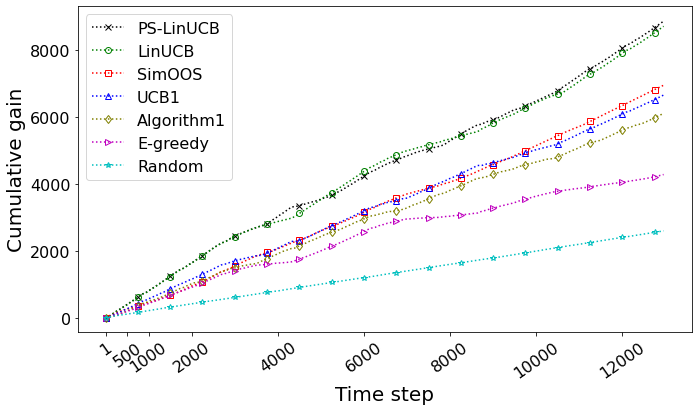

In [213]:
plot_gains({
    'Random': gain_random,
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
},
)


# Adding non-stationarity


In [214]:
inverted_regions = [
    slice(3000, 7000),
#     slice(6000, 7000),
]

In [215]:
# We invert arm 0 with 1 and 2 with 3 (
np.array(np.mean(all_rewards, axis=0), dtype=int)

array([0, 0, 0, 0, 0])

In [216]:
arm_from_to = {
    0: 1,
    1: 0,
    2: 3,
    3: 2
}

In [217]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

for region in inverted_regions:
    for arm_from in arm_from_to:
        arm_to = arm_from_to[arm_from]
        
        new_rewards[region, arm_to] = all_rewards[region, arm_from]
        

In [218]:
new_contexts.shape, new_rewards.shape

((12960, 5), (12960, 5))

## Testing on non-stationary data

In [219]:
np.random.seed(42)

In [220]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):
    p_random = algorithms.RandomPolicy()
    gain_random = evaluation.evaluate_on_synthetic_data(
        p_random,
        new_contexts,
        new_rewards,
        costs_vector,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_random
    
gain_random = np.mean(gains, axis=0)
print(f"Average gain: {gain_random[-1]}")

Random policy
Total gain: 2616.0
	Total reward: 2616.0
	Total cost: 0
Execution time: 0.1s

Random policy
Total gain: 2550.0
	Total reward: 2550.0
	Total cost: 0
Execution time: 0.1s

Random policy
Total gain: 2566.0
	Total reward: 2566.0
	Total cost: 0
Execution time: 0.1s

Random policy
Total gain: 2594.0
	Total reward: 2594.0
	Total cost: 0
Execution time: 0.1s

Random policy
Total gain: 2581.0
	Total reward: 2581.0
	Total cost: 0
Execution time: 0.1s

Average gain: 2581.4


In [221]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=0.01, n_arms=new_rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        new_contexts,
        new_rewards,
        costs_vector,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_egreedy
    
gain_egreedy = np.mean(gains, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.01)
Total gain: 3767.0
	Total reward: 3767.0
	Total cost: 0
Execution time: 0.1s

E-greedy(epsilon=0.01)
Total gain: 3038.0
	Total reward: 3038.0
	Total cost: 0
Execution time: 0.1s

E-greedy(epsilon=0.01)
Total gain: 3695.0
	Total reward: 3695.0
	Total cost: 0
Execution time: 0.1s

E-greedy(epsilon=0.01)
Total gain: 3548.0
	Total reward: 3548.0
	Total cost: 0
Execution time: 0.1s

E-greedy(epsilon=0.01)
Total gain: 3726.0
	Total reward: 3726.0
	Total cost: 0
Execution time: 0.1s

Average gain: 3554.8


In [222]:
ucb_alg = algorithms.UCB1(
        n_trials=NUM_OF_TRIALS,
        n_arms=new_rewards.shape[1],
        alpha=0.45,
    )

gain_ucb = evaluation.evaluate_on_synthetic_data(
    ucb_alg,
    new_contexts,
    new_rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)
gains[i, :] = gain_ucb



UCB1 (α=0.45)
Total gain: 6297.0
	Total reward: 6297.0
	Total cost: 0
Execution time: 0.1s



In [223]:
linucb = algorithms.LinUCB(
    n_trials=NUM_OF_TRIALS,
    context_dimension=new_contexts.shape[1],
    n_arms=new_rewards.shape[1],
    alpha=0.45,
)
gain_linucb = evaluation.evaluate_on_synthetic_data(
    linucb,
    new_contexts,
    new_rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)
gains[i, :] = gain_linucb



LinUCB (alpha=0.45)
Total gain: 7072.999999998172
	Total reward: 7721.0
	Total cost: 647.9999999999584
Execution time: 1.0s



In [237]:
ps_linucb = algorithms.PSLinUCB(
    n_trials=NUM_OF_TRIALS,
    context_dimension=new_contexts.shape[1],
    n_arms=new_rewards.shape[1],
    alpha=0.1,
    omega=500,
    delta=0.15,
)


gain_pslinucb = evaluation.evaluate_on_synthetic_data(
    ps_linucb,
    new_contexts,
    new_rewards,
    costs_vector,
    stop_after=NUM_OF_TRIALS,
)
change_points = ps_linucb.change_points
gains[i, :] = gain_pslinucb



PSLinUCB (alpha=0.1, omega=500, delta=0.15)
Total gain: 5977.99999999817
	Total reward: 6626.0
	Total cost: 647.9999999999584
Execution time: 1.2s



In [225]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=0.1,
        delta_SimOOS=0.08,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_simoos

gain_simoos = np.mean(gains, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.00519108772277832 seconds
Trial 0, time 2022-04-11 22:49:50.264727
Trial 500, time 2022-04-11 22:51:01.074487
Trial 1000, time 2022-04-11 22:52:21.917303
Trial 1500, time 2022-04-11 22:53:42.474457
Trial 2000, time 2022-04-11 22:54:34.496554
Trial 2500, time 2022-04-11 22:54:43.948701
Trial 3000, time 2022-04-11 22:54:47.743116
Trial 3500, time 2022-04-11 22:54:48.250782
Trial 4000, time 2022-04-11 22:54:48.922318
Trial 4500, time 2022-04-11 22:54:49.537349
Trial 5000, time 2022-04-11 22:54:50.253264
Trial 5500, time 2022-04-11 22:54:50.832016
Trial 6000, time 2022-04-11 22:54:51.200073
Trial 6500, time 2022-04-11 22:54:51.784136
Trial 7000, time 2022-04-11 22:54:52.575077
Trial 7500, time 2022-04-11 22:54:54.156362
Trial 8000, time 2022-04-11 22:54:54.920696
Trial 8500, time 2022-04-11 22:54:55.383433
Trial 9000, time 2022-04-11 22:54:56.192091
Trial 9500, time 2022-04-11 22:54:56.574047
Trial 10000, time 2022-04-11 22:54:56.966409
Trial 10500, time 2022-04-11 22:54:57.505109
T

In [226]:
# gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
# for i in range(NUM_REPETITIONS):

s = time.time()
p_alg1 = algorithms.Algorithm1(
    all_contexts=new_contexts, 
    number_of_actions=new_rewards.shape[1],
    max_no_red_context=new_contexts.shape[1],
    beta=1.0,
    delta=0.1,
    window_length=1000,
)
print(f"Took {time.time() - s} seconds")

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s = time.time()
    gain_alg1 = evaluation.evaluate_on_synthetic_data(
        p_alg1,
        new_contexts[:NUM_OF_TRIALS],
        new_rewards[:NUM_OF_TRIALS],
        costs_vector[:NUM_OF_TRIALS],
        stop_after=NUM_OF_TRIALS,
    )
    print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_alg1

# gain_alg1 = np.mean(gains, axis=0)
# print(f"Average gain: {gain_alg1[-1]}")

Took 0.04187488555908203 seconds
Round 0, time 2022-04-11 23:02:29.706209
Round 500, time 2022-04-11 23:07:10.614721
Round 1000, time 2022-04-11 23:22:54.836873
Round 1500, time 2022-04-11 23:46:17.588665
Round 2000, time 2022-04-12 00:09:51.438772
Round 2500, time 2022-04-12 00:33:46.348214
Round 3000, time 2022-04-12 00:57:27.581038
Round 3500, time 2022-04-12 01:21:46.496573
Round 4000, time 2022-04-12 01:46:19.463525
Round 4500, time 2022-04-12 02:10:59.691960
Round 5000, time 2022-04-12 02:35:48.923548
Round 5500, time 2022-04-12 03:00:30.684688
Round 6000, time 2022-04-12 03:25:17.812178
Round 6500, time 2022-04-12 03:50:04.067645
Round 7000, time 2022-04-12 04:14:30.160823
Round 7500, time 2022-04-12 04:39:11.635450
Round 8000, time 2022-04-12 05:03:38.473824
Round 8500, time 2022-04-12 05:28:29.861518
Round 9000, time 2022-04-12 05:53:06.020866
Round 9500, time 2022-04-12 06:17:49.036188
Round 10000, time 2022-04-12 06:42:30.999459
Round 10500, time 2022-04-12 07:07:11.043663
R

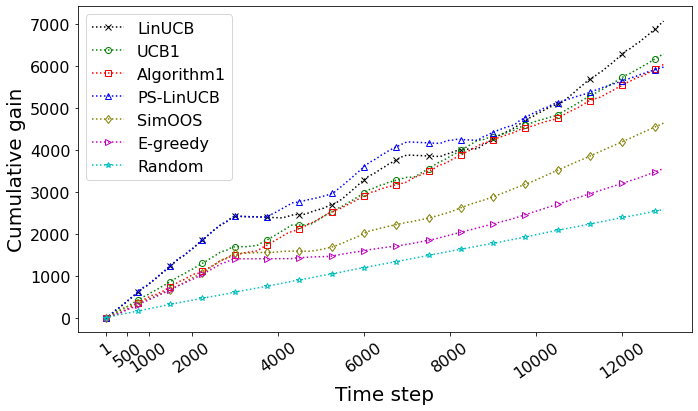

In [239]:
plot_gains({
    'Random': gain_random,
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
},
)


In [232]:
gain_pslinucb[3200:3400]

array([2414.95, 2414.9 , 2414.85, 2414.8 , 2414.75, 2414.7 , 2414.65,
       2414.6 , 2414.55, 2414.5 , 2414.45, 2414.4 , 2414.35, 2414.3 ,
       2414.25, 2414.2 , 2414.15, 2414.1 , 2414.05, 2414.  , 2413.95,
       2413.9 , 2413.85, 2413.8 , 2413.75, 2413.7 , 2413.65, 2413.6 ,
       2413.55, 2413.5 , 2413.45, 2413.4 , 2413.35, 2413.3 , 2413.25,
       2413.2 , 2413.15, 2413.1 , 2413.05, 2413.  , 2412.95, 2412.9 ,
       2412.85, 2412.8 , 2412.75, 2412.7 , 2412.65, 2412.6 , 2412.55,
       2412.5 , 2412.45, 2412.4 , 2412.35, 2412.3 , 2412.25, 2412.2 ,
       2412.15, 2412.1 , 2412.05, 2412.  , 2411.95, 2411.9 , 2411.85,
       2411.8 , 2411.75, 2411.7 , 2411.65, 2411.6 , 2411.55, 2411.5 ,
       2411.45, 2411.4 , 2411.35, 2411.3 , 2411.25, 2411.2 , 2411.15,
       2411.1 , 2411.05, 2411.  , 2410.95, 2410.9 , 2410.85, 2410.8 ,
       2410.75, 2410.7 , 2410.65, 2410.6 , 2410.55, 2410.5 , 2410.45,
       2410.4 , 2410.35, 2410.3 , 2410.25, 2410.2 , 2410.15, 2410.1 ,
       2410.05, 2410

## Debugging

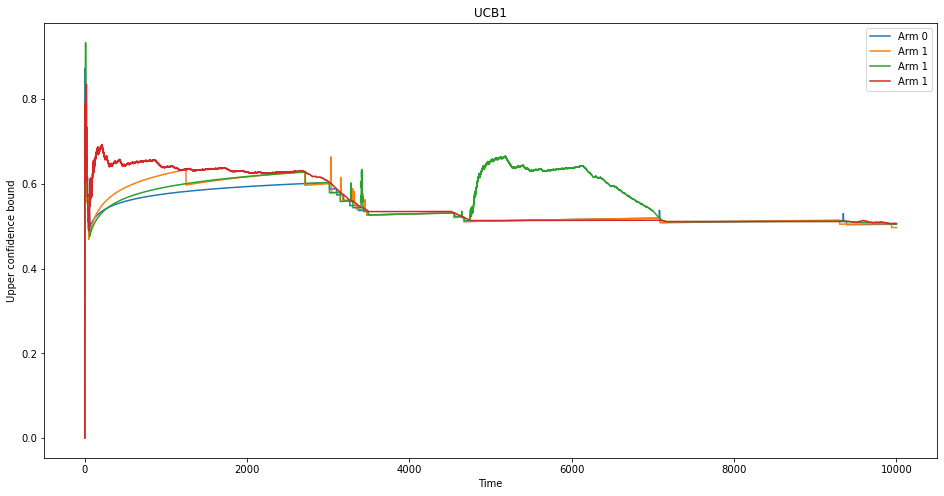

In [241]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
until = 10000
ax.plot(ucb_alg.ucbs[:until, 0], label=f"Arm 0");
ax.plot(ucb_alg.ucbs[:until, 1], label=f"Arm 1");
ax.plot(ucb_alg.ucbs[:until, 2], label=f"Arm 1");
ax.plot(ucb_alg.ucbs[:until, 3], label=f"Arm 1");

ax.set_title('UCB1');
ax.set_xlabel('Time');
ax.set_ylabel('Upper confidence bound');
plt.legend();

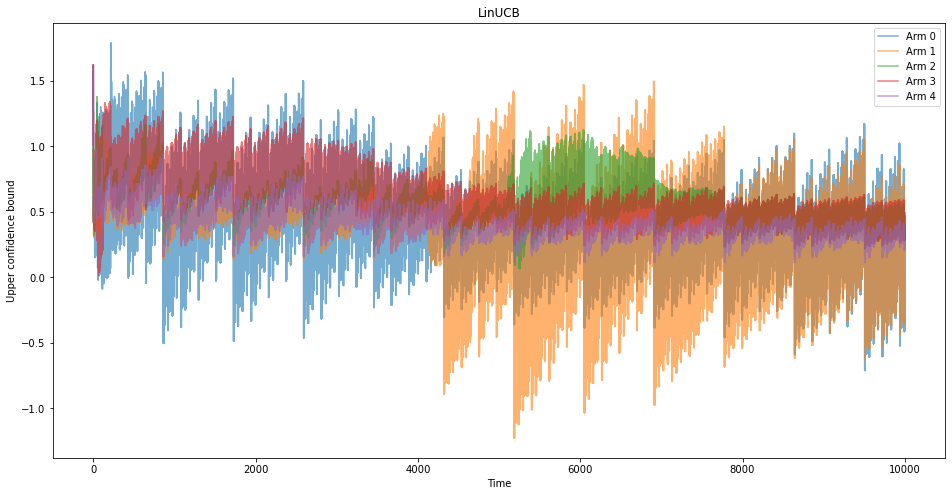

In [240]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
for i in range(5):
    ax.plot(linucb.ucbs[:until, i], label=f"Arm {i}", alpha=0.6);
ax.set_title('LinUCB');
ax.set_xlabel('Time');
ax.set_ylabel('Upper confidence bound');
plt.legend();

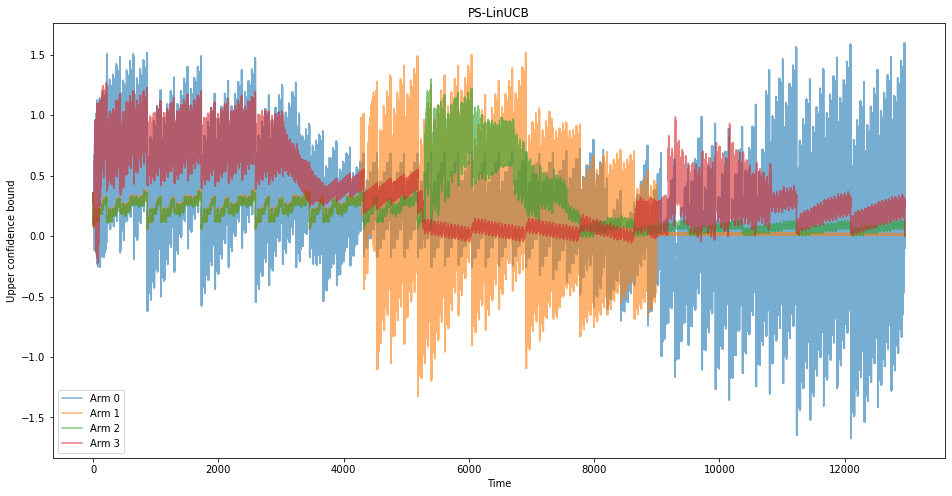

In [238]:
fig, ax = plt.subplots(1,1, figsize=(16, 8))
for i in range(4):
    ax.plot(ps_linucb.ucbs[:, i], label=f"Arm {i}", alpha=0.6);
ax.set_title('PS-LinUCB');
ax.set_xlabel('Time');
ax.set_ylabel('Upper confidence bound');
plt.legend();